In [195]:
!pip install torch==1.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 2.4 MB/s eta 0:00:0000:0100:03
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1+cu111
    Uninstalling torch-1.8.1+cu111:
      Successfully uninstalled torch-1.8.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.9.1+cu111 requires torch==1.8.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.8.1 requires torch==1.8.1, but you have torch 1.9.0 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import torch
from tqdm.notebook import tqdm
import json
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torch import cuda
import random
from sklearn.utils import shuffle

In [2]:
torch.__version__

'1.9.0+cu102'

In [3]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
       
    def __getitem__(self, index):
        
        X = self.X.iloc[index].to_numpy()
        y = self.y.iloc[index].to_numpy()
        tensorX =  torch.Tensor(X).view(1,9)
        tensorY = torch.Tensor(y).view(1,8)
        return tensorX,tensorY
    
    def __len__(self):
        return len(self.X)

In [4]:
def plot_loss(Loss_train=None, Loss_val=None):
    plt.figure(figsize=(12, 5))
    if Loss_val != None:
        plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    if Loss_train != None:
        plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.legend()
    plt.show()

In [5]:
from IPython import display



def train_NN(model, opt, loss_fn, epochs, train_loader, val_loader):

    for epoch in range(epochs):
        # печатаем номер текущей эпохи
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # 1. Обучаем сеть на картинках из train_loader
        model.train()  # train mode
        
        avg_train_loss = 0
        losses = []
        for i, batch in enumerate(train_loader):
            # переносим батч на GPU
            X,Y = batch
            Y = Y.view(-1,8).to(device)
            X = X.view(-1,9).to(device)
            # получаем ответы сети на батч
            Y_pred = model(X)
            
            # считаем лосс, делаем шаг оптимизации сети
            loss = loss_fn(Y_pred, Y)
            loss.backward()  
            opt.step()  
            opt.zero_grad()
            losses.append(loss.item())

            avg_train_loss += loss / len(train_loader)
        
        display.clear_output(wait=True)
        time.sleep(1)
        plot_loss(losses)
        display.display(plt.gcf())

        # выводим средний лосс на тренировочной выборке за эпоху
        print('avg train loss: %f' % avg_train_loss)
        
        # 2. Тестируем сеть на картинках из val_loader
        model.eval() 

        avg_val_loss = 0
        for i, batch in enumerate(val_loader):
            # переносим батч на GPU
            X,Y = batch
            Y = Y.view(-1, 8).to(device)
            X = X.view(-1,9).to(device)
            # получаем ответы сети на батч
            Y_pred = model(X)
            # считаем лосс на батче
            loss = loss_fn(Y_pred, Y)

            avg_val_loss += loss / len(val_loader)
        
        # выводим средний лосс на валидационных данных
        print('avg val loss: %f' % avg_val_loss)

In [22]:
from IPython import display



def train_main(model, opt, loss_fn, epochs, train_loader):

    for epoch in range(epochs):
        # печатаем номер текущей эпохи
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # 1. Обучаем сеть на картинках из train_loader
        model.train()  # train mode
        
        avg_train_loss = 0
        losses = []
        for i, batch in enumerate(train_loader):
            # переносим батч на GPU
            X,Y = batch
            Y = Y.view(-1,8).to(device)
            X = X.view(-1,9).to(device)
            # получаем ответы сети на батч
            Y_pred = model(X)
            
            # считаем лосс, делаем шаг оптимизации сети
            loss = loss_fn(Y_pred, Y)
            loss.backward()  
            opt.step()  
            opt.zero_grad()
            losses.append(loss.item())

            avg_train_loss += loss / len(train_loader)
        
        display.clear_output(wait=True)
        time.sleep(1)
        plot_loss(losses)
        display.display(plt.gcf())

        # выводим средний лосс на тренировочной выборке за эпоху
        print('avg train loss: %f' % avg_train_loss)

In [7]:
class CustomFCL(nn.Module):
    def __init__(self):
        super(CustomFCL, self).__init__()
        
        self.len = 8
        self.fc1 = nn.Linear(9, 50)
        self.fc2 = nn.Linear(50, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 200)
        self.fc5 = nn.Linear(200, self.len)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [8]:
dataframe_train = pd.read_pickle('data_for_train')

In [9]:
dataframe_train

,Основная отрасль,"Среднесписочная численность персонала, работающего в Москве, чел. 2021","Средняя з.п. сотрудников, работающих в Москве, тыс.руб. 2021","Налоги, уплаченные в бюджет Москвы, тыс.руб. 2022","Налог на прибыль, тыс.руб. 2022","Налог на имущество, тыс.руб. 2022","Налог на землю, тыс.руб. 2022","НДФЛ, тыс.руб. 2022","Транспортный налог, тыс.руб. 2022",Прочие налоги 2022,...,Кадастровая стоимость земли тыс.руб. 2022,Адм.округ Москвы,"Средн.кадастр.стоимость \n1 кв.м., руб.",Возможная площадь кв.м.,Возможная площадь недвижимости кв.м.,Прибыль тыс.руб. 2022,Аренда Земли,Аренда Здания,Площадь аренды,Цена за аренду тыс.руб.
0,0,3281.812175,85.59601,919608.1706,270214.857,41792.75174,3094.458,576017.4715,119.18775,28369.44464,...,206297.2,0,15492.36,13316.060303,17413.646558,1351074.285,1,1,1000,0.00000
1,0,3281.812175,85.59601,919608.1706,270214.857,41792.75174,3094.458,576017.4715,119.18775,28369.44464,...,206297.2,1,11703.22,17627.388018,17413.646558,1351074.285,1,1,200,0.00000
2,0,3281.812175,85.59601,919608.1706,270214.857,41792.75174,3094.458,576017.4715,119.18775,28369.44464,...,206297.2,2,4111.50,50175.653654,17413.646558,1351074.285,1,1,1000,0.00000
3,0,3281.812175,85.59601,919608.1706,270214.857,41792.75174,3094.458,576017.4715,119.18775,28369.44464,...,206297.2,3,5333.94,38676.325568,17413.646558,1351074.285,1,1,200,0.00000
4,0,3281.812175,85.59601,919608.1706,270214.857,41792.75174,3094.458,576017.4715,119.18775,28369.44464,...,206297.2,4,20532.99,10047.109554,17413.646558,1351074.285,1,1,200,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127795,24,11.166667,75.142503,0.0,0.0,0.0,0.0,862.62347,0.0,0.0,...,0.0,7,2890.51,0.0,0.0,0.0,0,0,1000,43.35765
127796,24,11.166667,75.142503,0.0,0.0,0.0,0.0,862.62347,0.0,0.0,...,0.0,8,63274.79,0.0,0.0,0.0,0,0,200,189.82437
127797,24,11.166667,75.142503,0.0,0.0,0.0,0.0,862.62347,0.0,0.0,...,0.0,9,13510.37,0.0,0.0,0.0,0,0,200,40.53111
127798,24,11.166667,75.142503,0.0,0.0,0.0,0.0,862.62347,0.0,0.0,...,0.0,10,14086.97,0.0,0.0,0.0,0,0,200,42.26091


In [10]:
dataframe_train['Аренда Земли'] = dataframe_train.apply(lambda x: 0 if x['Налог на землю, тыс.руб. 2022'] > 0.0 else 1, axis=1)
dataframe_train['Аренда Здания'] = dataframe_train.apply(lambda x: 0 if x['Налог на имущество, тыс.руб. 2022'] > 0.0 else 1, axis=1)
dataframe_train['Площадь аренды'] = dataframe_train.apply(lambda x: 0 if x['Аренда Земли'] == 0 and x['Аренда Здания'] == 0 else x['Площадь аренды'], axis=1)

In [11]:
train = dataframe_train.iloc[:, [0,1, 11, 14,16,17,19,20,21 ]].apply(pd.to_numeric)
train

,Основная отрасль,"Среднесписочная численность персонала, работающего в Москве, чел. 2021",Кол-во единиц,Адм.округ Москвы,Возможная площадь кв.м.,Возможная площадь недвижимости кв.м.,Аренда Земли,Аренда Здания,Площадь аренды
0,0,3281.812175,15,0,13316.060303,17413.646558,0,0,0
1,0,3281.812175,15,1,17627.388018,17413.646558,0,0,0
2,0,3281.812175,15,2,50175.653654,17413.646558,0,0,0
3,0,3281.812175,15,3,38676.325568,17413.646558,0,0,0
4,0,3281.812175,15,4,10047.109554,17413.646558,0,0,0
...,...,...,...,...,...,...,...,...,...
127795,24,11.166667,100,7,0.000000,0.000000,1,1,1000
127796,24,11.166667,100,8,0.000000,0.000000,1,1,200
127797,24,11.166667,100,9,0.000000,0.000000,1,1,200
127798,24,11.166667,100,10,0.000000,0.000000,1,1,200


In [12]:
def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    index = []
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        index.append(df_scaled[column].abs().max())
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled, index

train, index_input = maximum_absolute_scaling(train)

In [13]:
train

,Основная отрасль,"Среднесписочная численность персонала, работающего в Москве, чел. 2021",Кол-во единиц,Адм.округ Москвы,Возможная площадь кв.м.,Возможная площадь недвижимости кв.м.,Аренда Земли,Аренда Здания,Площадь аренды
0,0.0,0.323586,0.15,0.000000,0.006074,0.048237,0.0,0.0,0.0
1,0.0,0.323586,0.15,0.090909,0.008041,0.048237,0.0,0.0,0.0
2,0.0,0.323586,0.15,0.181818,0.022888,0.048237,0.0,0.0,0.0
3,0.0,0.323586,0.15,0.272727,0.017642,0.048237,0.0,0.0,0.0
4,0.0,0.323586,0.15,0.363636,0.004583,0.048237,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
127795,1.0,0.001101,1.00,0.636364,0.000000,0.000000,1.0,1.0,1.0
127796,1.0,0.001101,1.00,0.727273,0.000000,0.000000,1.0,1.0,0.2
127797,1.0,0.001101,1.00,0.818182,0.000000,0.000000,1.0,1.0,0.2
127798,1.0,0.001101,1.00,0.909091,0.000000,0.000000,1.0,1.0,0.2


In [14]:
answers = dataframe_train.iloc[:, [1,2, 4,5,6,7,8,9,10,12,13, -1]]
answers['Зарплатные вылпаты тыс.руб'] = answers.iloc[:, 0] * answers.iloc[:, 1]
answers['Страхование тыс.руб'] = answers['Зарплатные вылпаты тыс.руб']*0.3
answers['Полная сумма затрат тыс.руб.'] = answers.iloc[:, 2:].apply(lambda x: sum(x), axis=1)
answers = answers.apply(pd.to_numeric)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [15]:
answers['Затраты от тыс.руб.'] = answers['Полная сумма затрат тыс.руб.'] * 0.85
answers['Затраты до тыс.руб.'] = answers['Полная сумма затрат тыс.руб.'] * 1.15
answers = answers.apply(pd.to_numeric)
answers, index_out = maximum_absolute_scaling(answers)

In [16]:
answers

,"Среднесписочная численность персонала, работающего в Москве, чел. 2021","Средняя з.п. сотрудников, работающих в Москве, тыс.руб. 2021","Налог на прибыль, тыс.руб. 2022","Налог на имущество, тыс.руб. 2022","Налог на землю, тыс.руб. 2022","НДФЛ, тыс.руб. 2022","Транспортный налог, тыс.руб. 2022",Прочие налоги 2022,Cумма затрат на оборудование тыс.руб.,"Кадастровая стоимость имущества, тыс.руб. 2022",Кадастровая стоимость земли тыс.руб. 2022,Цена за аренду тыс.руб.,Зарплатные вылпаты тыс.руб,Страхование тыс.руб,Полная сумма затрат тыс.руб.,Затраты от тыс.руб.,Затраты до тыс.руб.
0,0.323586,0.103599,0.137409,0.048237,0.032556,0.189287,0.0041,0.007244,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102,0.078102
1,0.323586,0.103599,0.137409,0.048237,0.032556,0.189287,0.0041,0.007244,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102,0.078102
2,0.323586,0.103599,0.137409,0.048237,0.032556,0.189287,0.0041,0.007244,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102,0.078102
3,0.323586,0.103599,0.137409,0.048237,0.032556,0.189287,0.0041,0.007244,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102,0.078102
4,0.323586,0.103599,0.137409,0.048237,0.032556,0.189287,0.0041,0.007244,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102,0.078102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127795,0.001101,0.090947,0.000000,0.000000,0.000000,0.000283,0.0000,0.000000,0.322811,0.000000,0.000000,0.045682,0.000858,0.000858,0.005925,0.005925,0.005925
127796,0.001101,0.090947,0.000000,0.000000,0.000000,0.000283,0.0000,0.000000,0.322811,0.000000,0.000000,0.200000,0.000858,0.000858,0.005928,0.005928,0.005928
127797,0.001101,0.090947,0.000000,0.000000,0.000000,0.000283,0.0000,0.000000,0.322811,0.000000,0.000000,0.042704,0.000858,0.000858,0.005925,0.005925,0.005925
127798,0.001101,0.090947,0.000000,0.000000,0.000000,0.000283,0.0000,0.000000,0.322811,0.000000,0.000000,0.044526,0.000858,0.000858,0.005925,0.005925,0.005925


In [17]:
X = train.apply(pd.to_numeric).copy()
Y = answers[['Cумма затрат на оборудование тыс.руб.','Кадастровая стоимость имущества, тыс.руб. 2022','Кадастровая стоимость земли тыс.руб. 2022','Цена за аренду тыс.руб.','Зарплатные вылпаты тыс.руб','Страхование тыс.руб','Затраты от тыс.руб.', 'Затраты до тыс.руб.']].apply(pd.to_numeric)






In [18]:
Y

,Cумма затрат на оборудование тыс.руб.,"Кадастровая стоимость имущества, тыс.руб. 2022",Кадастровая стоимость земли тыс.руб. 2022,Цена за аренду тыс.руб.,Зарплатные вылпаты тыс.руб,Страхование тыс.руб,Затраты от тыс.руб.,Затраты до тыс.руб.
0,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102
1,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102
2,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102
3,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102
4,0.005282,0.048237,0.032556,0.000000,0.287320,0.287320,0.078102,0.078102
...,...,...,...,...,...,...,...,...
127795,0.322811,0.000000,0.000000,0.045682,0.000858,0.000858,0.005925,0.005925
127796,0.322811,0.000000,0.000000,0.200000,0.000858,0.000858,0.005928,0.005928
127797,0.322811,0.000000,0.000000,0.042704,0.000858,0.000858,0.005925,0.005925
127798,0.322811,0.000000,0.000000,0.044526,0.000858,0.000858,0.005925,0.005925


In [150]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=800)

In [19]:
X,Y = shuffle(X, Y, random_state=800)

In [151]:
train_data = CustomDataset(X_train, y_train)
val_data = CustomDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

In [20]:
train_data = CustomDataset(X, Y)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

In [24]:
device = 'cuda' if cuda.is_available() else 'cpu'
device = 'cpu'
custom_model = CustomFCL().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.0001)

train_NN(custom_model, optimizer, criterion, 20, train_loader)

TypeError: train_NN() missing 1 required positional argument: 'val_loader'

<Figure size 432x288 with 0 Axes>

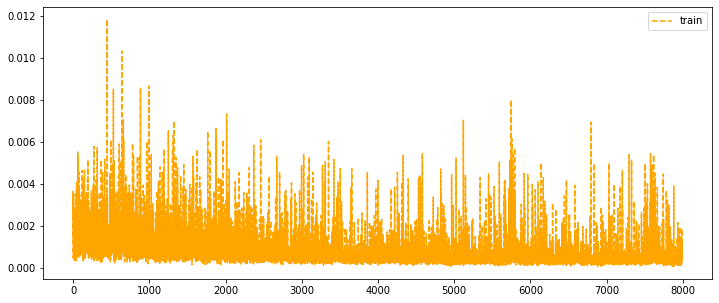

<Figure size 432x288 with 0 Axes>

avg train loss: 0.000883
* Epoch 3/20


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [25]:
device = 'cuda' if cuda.is_available() else 'cpu'
device = 'cpu'
custom_model = CustomFCL().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.0001)

train_main(custom_model, optimizer, criterion, 20, train_loader)

In [31]:
from sklearn.multioutput import MultiOutputRegressor


params = {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3,
         'verbose':100}

estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params))

In [32]:
estimator.fit(X, Y)

      Iter       Train Loss   Remaining Time 
         1           0.0356           32.23s
         2           0.0288           31.38s
         3           0.0234           31.01s
         4           0.0189           30.85s
         5           0.0154           30.72s
         6           0.0125           30.50s
         7           0.0101           30.28s
         8           0.0082           30.06s
         9           0.0066           29.89s
        10           0.0054           29.66s
        11           0.0044           29.51s
        12           0.0036           29.35s
        13           0.0029           28.65s
        14           0.0023           27.85s
        15           0.0019           27.15s
        16           0.0016           26.52s
        17           0.0013           25.96s
        18           0.0010           25.44s
        19           0.0008           24.96s
        20           0.0007           24.54s
        21           0.0006           24.14s
        2

       184           0.0000            1.76s
       185           0.0000            1.65s
       186           0.0000            1.54s
       187           0.0000            1.43s
       188           0.0000            1.32s
       189           0.0000            1.21s
       190           0.0000            1.10s
       191           0.0000            0.99s
       192           0.0000            0.88s
       193           0.0000            0.77s
       194           0.0000            0.66s
       195           0.0000            0.55s
       196           0.0000            0.44s
       197           0.0000            0.33s
       198           0.0000            0.22s
       199           0.0000            0.11s
       200           0.0000            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0003           21.49s
         2           0.0002           21.43s
         3           0.0002           21.41s
         4           0.0002           21.42s
         

       166           0.0000            3.70s
       167           0.0000            3.59s
       168           0.0000            3.48s
       169           0.0000            3.37s
       170           0.0000            3.26s
       171           0.0000            3.16s
       172           0.0000            3.05s
       173           0.0000            2.94s
       174           0.0000            2.83s
       175           0.0000            2.72s
       176           0.0000            2.61s
       177           0.0000            2.50s
       178           0.0000            2.39s
       179           0.0000            2.28s
       180           0.0000            2.17s
       181           0.0000            2.07s
       182           0.0000            1.96s
       183           0.0000            1.85s
       184           0.0000            1.74s
       185           0.0000            1.63s
       186           0.0000            1.52s
       187           0.0000            1.41s
       188

       148           0.0000            5.74s
       149           0.0000            5.63s
       150           0.0000            5.52s
       151           0.0000            5.41s
       152           0.0000            5.30s
       153           0.0000            5.19s
       154           0.0000            5.08s
       155           0.0000            4.97s
       156           0.0000            4.86s
       157           0.0000            4.75s
       158           0.0000            4.64s
       159           0.0000            4.53s
       160           0.0000            4.42s
       161           0.0000            4.31s
       162           0.0000            4.20s
       163           0.0000            4.08s
       164           0.0000            3.97s
       165           0.0000            3.86s
       166           0.0000            3.75s
       167           0.0000            3.64s
       168           0.0000            3.53s
       169           0.0000            3.42s
       170

       130           0.0000            7.50s
       131           0.0000            7.41s
       132           0.0000            7.30s
       133           0.0000            7.19s
       134           0.0000            7.09s
       135           0.0000            6.98s
       136           0.0000            6.87s
       137           0.0000            6.77s
       138           0.0000            6.66s
       139           0.0000            6.55s
       140           0.0000            6.45s
       141           0.0000            6.34s
       142           0.0000            6.23s
       143           0.0000            6.13s
       144           0.0000            6.02s
       145           0.0000            5.92s
       146           0.0000            5.81s
       147           0.0000            5.70s
       148           0.0000            5.60s
       149           0.0000            5.49s
       150           0.0000            5.38s
       151           0.0000            5.27s
       152

       112           0.0000            9.57s
       113           0.0000            9.46s
       114           0.0000            9.35s
       115           0.0000            9.24s
       116           0.0000            9.13s
       117           0.0000            9.03s
       118           0.0000            8.92s
       119           0.0000            8.81s
       120           0.0000            8.70s
       121           0.0000            8.59s
       122           0.0000            8.49s
       123           0.0000            8.38s
       124           0.0000            8.27s
       125           0.0000            8.16s
       126           0.0000            8.05s
       127           0.0000            7.94s
       128           0.0000            7.83s
       129           0.0000            7.72s
       130           0.0000            7.61s
       131           0.0000            7.51s
       132           0.0000            7.40s
       133           0.0000            7.29s
       134

        94           0.0000           11.61s
        95           0.0000           11.50s
        96           0.0000           11.39s
        97           0.0000           11.28s
        98           0.0000           11.17s
        99           0.0000           11.06s
       100           0.0000           10.95s
       101           0.0000           10.84s
       102           0.0000           10.74s
       103           0.0000           10.63s
       104           0.0000           10.52s
       105           0.0000           10.41s
       106           0.0000           10.30s
       107           0.0000           10.19s
       108           0.0000           10.08s
       109           0.0000            9.97s
       110           0.0000            9.86s
       111           0.0000            9.75s
       112           0.0000            9.64s
       113           0.0000            9.53s
       114           0.0000            9.42s
       115           0.0000            9.31s
       116

        76           0.0000           13.68s
        77           0.0000           13.57s
        78           0.0000           13.46s
        79           0.0000           13.34s
        80           0.0000           13.23s
        81           0.0000           13.12s
        82           0.0000           13.00s
        83           0.0000           12.89s
        84           0.0000           12.79s
        85           0.0000           12.68s
        86           0.0000           12.57s
        87           0.0000           12.45s
        88           0.0000           12.34s
        89           0.0000           12.23s
        90           0.0000           12.12s
        91           0.0000           12.01s
        92           0.0000           11.89s
        93           0.0000           11.79s
        94           0.0000           11.68s
        95           0.0000           11.58s
        96           0.0000           11.47s
        97           0.0000           11.36s
        98

        58           0.0000           15.69s
        59           0.0000           15.58s
        60           0.0000           15.47s
        61           0.0000           15.36s
        62           0.0000           15.25s
        63           0.0000           15.13s
        64           0.0000           15.01s
        65           0.0000           14.90s
        66           0.0000           14.79s
        67           0.0000           14.69s
        68           0.0000           14.58s
        69           0.0000           14.46s
        70           0.0000           14.35s
        71           0.0000           14.24s
        72           0.0000           14.13s
        73           0.0000           14.03s
        74           0.0000           13.91s
        75           0.0000           13.80s
        76           0.0000           13.68s
        77           0.0000           13.57s
        78           0.0000           13.46s
        79           0.0000           13.35s
        80

MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=6,
                                                         min_samples_leaf=3,
                                                         min_samples_split=3,
                                                         n_estimators=200,
                                                         verbose=100))

In [33]:
import joblib
from joblib import dump, load

dump(estimator, 'GBEstimator_hakaton_new.joblib')

['GBEstimator_hakaton_new.joblib']

In [98]:
joblib.__version__

'1.1.0'

In [99]:
index_input

[24, 10142.0, 100, 11, 2192246.751841947, 361001.015125, 1, 1, 1000]

In [63]:
msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)

In [71]:
y_pred = estimator.predict(X_test)

In [13]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr_reg = MultiOutputRegressor(linear_model.Ridge())
svr_reg.fit(X_train, y_train)

MultiOutputRegressor(estimator=Ridge())

In [14]:
y_pred = svr_reg.predict(X_test)

In [79]:
index_out = np.array(index_out)

In [85]:
test_pred = y_pred*index_out[[-2, -1]]

In [86]:
real = y_test*index_out[[-2, -1]]

In [89]:
test_pred

array([[173954.93972981, 235350.80081093],
       [ 35215.04133365,  47643.8794514 ],
       [139000.39137614, 188059.35303831],
       ...,
       [ 92172.67505878, 124704.20743247],
       [173378.86552006, 234571.40629184],
       [701272.5351545 , 948780.48873845]])

In [88]:
real

,Затраты от тыс.руб.,Затраты до тыс.руб.
38030,141131.404902,190942.488985
104303,31017.906580,41965.403019
107370,134609.431297,182118.642343
28656,83610.876124,113120.597109
4962,57204.470046,77394.283004
...,...,...
26025,95108.836085,128676.660586
20813,29881.235500,40427.553911
26882,82931.491739,112201.430000
97032,160233.983068,216787.153563


In [91]:
mean_absolute_error(real, test_pred)

22301.90361382116

In [17]:
len(X.columns)

9

In [102]:
index_out[[-2,-1]]

array([39017779.45996793, 52788760.44583896])

In [176]:
index_input = np.array(index_input)
test = np.array([12, 300, 5, 4, 500, 200, 0,0,0])
final = test/index_input
final = torch.Tensor(final).to(device)

In [177]:
with torch.no_grad():
    custom_model.eval()
    answer = custom_model(final)

In [36]:
index_out = np.array(index_out)
index_out

array([1.01420000e+04, 8.26221609e+02, 1.96649650e+06, 8.66402436e+05,
       9.50506674e+04, 3.04308605e+06, 2.90668515e+04, 3.91612476e+06,
       8.36286438e+05, 4.33201218e+07, 6.33671116e+06, 9.49121850e+02,
       9.77688800e+05, 2.93306640e+05, 4.59032700e+07, 3.90177795e+07,
       5.27887604e+07])

In [179]:
answer = answer.detach().cpu().numpy()
asnwer = index_out[[8, 9, 10,11,12,13,15,16]]*answer

In [180]:
title = ['Cумма затрат на оборудование тыс.руб.','Кадастровая стоимость имущества, тыс.руб. 2022','Кадастровая стоимость земли тыс.руб. 2022','Цена за аренду тыс.руб.','Зарплатные вылпаты тыс.руб','Страхование тыс.руб','Затраты от тыс.руб.', 'Затраты до тыс.руб.']
asnwer

array([-2.49161095e+04,  1.14101975e+05,  1.24952551e+05,  1.26178691e+01,
        1.86075787e+04,  4.99687744e+03,  4.20508576e+05,  4.18452992e+05])

In [181]:
for tit, value in zip(title, asnwer):
    print(tit, value)

Cумма затрат на оборудование тыс.руб. -24916.109475888916
Кадастровая стоимость имущества, тыс.руб. 2022 114101.97469575623
Кадастровая стоимость земли тыс.руб. 2022 124952.5508032508
Цена за аренду тыс.руб. 12.617869126506289
Зарплатные вылпаты тыс.руб 18607.57866537571
Страхование тыс.руб 4996.877438211143
Затраты от тыс.руб. 420508.57626711467
Затраты до тыс.руб. 418452.9918800568


In [26]:
torch.save(custom_model, 'FCLHakmodel_new')

In [186]:
index_input 

array([2.40000000e+01, 1.01420000e+04, 1.00000000e+02, 1.10000000e+01,
       2.19224675e+06, 3.61001015e+05, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+03])

In [187]:
index_out[[8, 9, 10,11,12,13,15,16]]

array([8.36286438e+05, 4.33201218e+07, 6.33671116e+06, 9.49121850e+02,
       9.77688800e+05, 2.93306640e+05, 3.90177795e+07, 5.27887604e+07])

52788760.44583896

In [193]:
torch.__version__

'1.8.1+cu111'

In [192]:
custom_model

CustomFCL(
  (fc1): Linear(in_features=9, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=8, bias=True)
  (relu): ReLU()
)

In [28]:
X.to_pickle('X')
Y.to_pickle('Y')

In [35]:
index_out[[8, 9, 10,11,12,13,15,16]]

TypeError: list indices must be integers or slices, not list

In [40]:
index_out[[8, 9, 10,11,12,13,15,16]]

array([8.36286438e+05, 4.33201218e+07, 6.33671116e+06, 9.49121850e+02,
       9.77688800e+05, 2.93306640e+05, 3.90177795e+07, 5.27887604e+07])

In [38]:
index_out.shape

(17,)

In [43]:
test = estimator.predict([[12, 100, 15 ,0,200,100,0,0,0]])

/home/user/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/home/user/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/home/user/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/home/user/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/home/user/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, 

In [47]:
test[0]*index_out[[8, 9, 10,11,12,13,15,16]]

array([ 2.76497367e+05,  4.33201263e+07,  3.49456299e+06, -4.07878181e-03,
        8.45866944e+05,  2.54613459e+05,  3.89395849e+07,  5.26762819e+07])

In [49]:
Y

,Cумма затрат на оборудование тыс.руб.,"Кадастровая стоимость имущества, тыс.руб. 2022",Кадастровая стоимость земли тыс.руб. 2022,Цена за аренду тыс.руб.,Зарплатные вылпаты тыс.руб,Страхование тыс.руб,Затраты от тыс.руб.,Затраты до тыс.руб.
38030,0.197504,0.000000,0.0,0.064978,0.000115,0.000115,0.003617,0.003617
104303,0.043250,0.000000,0.0,0.051910,0.000050,0.000050,0.000795,0.000795
107370,0.189066,0.000000,0.0,0.157737,0.000016,0.000016,0.003450,0.003450
28656,0.039871,0.001352,0.0,0.122421,0.000627,0.000627,0.002143,0.002143
4962,0.080124,0.000000,0.0,0.157737,0.000000,0.000000,0.001466,0.001466
...,...,...,...,...,...,...,...,...
1439,0.080124,0.000508,0.0,0.259552,0.009159,0.009159,0.002652,0.002652
125401,0.168290,0.000000,0.0,0.092479,0.004202,0.004202,0.003378,0.003378
71891,0.278621,0.000000,0.0,0.259552,0.000323,0.000323,0.005127,0.005127
109498,0.189066,0.000000,0.0,0.044526,0.000073,0.000073,0.003449,0.003449
